In [1]:
from math import sqrt
import pde
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from dateutil import parser
import numpy as np
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid
from IPython.display import HTML
from pde import DiffusionPDE, ScalarField, UnitGrid
from GPy.models import GPRegression
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.core import ContinuousParameter, ParameterSpace
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import itertools
from emukit.core.acquisition.acquisition_per_cost import acquisition_per_expected_cost
from emukit.core.interfaces.models import IModel
from sklearn.linear_model import LinearRegression
from emukit.experimental_design import ExperimentalDesignLoop
from sklearn.svm import SVR



In [2]:
from mfed.pde import pde_runner
from mfed.plot import plot

In [3]:
class CostModel(IModel):
    def __init__(self,pde_client):
        self.clf = SVR()
        self.pde_client = pde_client
        self.fit()
    
    def fit(self):
        dt = np.array(self.pde_client.cost)[:,0].reshape((-1,1))
        cost = np.array(self.pde_client.cost)[:,1]
        self.clf.fit(dt,cost)

    def predict(self, X: np.ndarray):
        w = self.clf.predict(X[:,0].reshape((-1,1))).reshape((-1,1))
        return (w,X)


In [15]:
f_y = lambda x: len(np.where(x > 4.25)[0])
param = {"pde_name":"brusselator","t_range":10,"diff":1,"dt":1e-03,"seed":100,"dim_data":1,"f_y":f_y}
pde_client = pde_runner(param,f_y)

In [16]:
dt_list = [1e-1,1e-2]
diff_list = np.linspace(0.1,0.9,2)
X = np.array(list(itertools.product(dt_list,diff_list)))

Y = pde_client(X)




100%|██████████| 4/4 [01:49<00:00, 27.34s/it]


In [17]:
# Boiler plate for plotting 
mesh_size = 50
space = ParameterSpace([ContinuousParameter('diff', X[:,0].min(), X[:,0].max()),
                        ContinuousParameter('dt', X[:,1].min(), X[:,1].max())])
x_monte_carlo = np.vstack([np.ones((mesh_size))*space.parameters[0].min,
                np.linspace(X[:,1].min(),X[:,1].max(),mesh_size)]).T


In [18]:

fig = go.Figure(data=[go.Scatter3d(x=X[:,0],y=X[:,1],z=Y.reshape((-1)),mode="markers",marker_symbol="x",marker_size=5)])
fig.show()

In [19]:
# Define and fit a GP model 

kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[0.1,0.1],variance=1)
model_gpy = GPRegression(X,Y,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_gpy.optimize()
print("Param: ",model_gpy.param_array)


Param:  [1.         0.12640179 0.1        0.05      ]


In [20]:



cost_model = CostModel(pde_client) # Fit a linear model on the costs 


model_emukit = GPyModelWrapper(model_gpy)
model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)

plot(X,Y,model_variance)





In [21]:

weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
plot(X,Y,weighted_variance)

In [22]:

model_emukit = GPyModelWrapper(model_gpy)

expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                        space = space,
                                        acquisition = weighted_variance,
                                        batch_size = 1)

In [ ]:
from GPy.inference.optimization import Optimizer
class uhmc(Optimizer):
    def __init__(self, *args, **kwargs):
        Optimizer.__init__(self, *args, **kwargs)
        self.opt_name = "Upper-bound HMC implementation"

    def opt(self, x_init, f_fp=None, f=None, fp=None):
        """
        Run the TNC optimizer

        """

        

        tnc_rcstrings = ['Local minimum', 'Converged', 'XConverged', 'Maximum number of f evaluations reached',
             'Line search failed', 'Function is constant']

        assert f_fp != None, "TNC requires f_fp"

        opt_dict = {}
        if self.xtol is not None:
            opt_dict['xtol'] = self.xtol
        if self.ftol is not None:
            opt_dict['ftol'] = self.ftol
        if self.gtol is not None:
            opt_dict['pgtol'] = self.gtol

        opt_result = optimize.fmin_tnc(f_fp, x_init, messages=self.messages,
                       maxfun=self.max_f_eval, **opt_dict)
        self.x_opt = opt_result[0]
        self.f_opt = f_fp(self.x_opt)[0]
        self.funct_eval = opt_result[1]
        self.status = tnc_rcstrings[opt_result[2]]

In [25]:
model_gpy.preferred_optimizer

'lbfgsb'

100%|██████████| 1/1 [00:22<00:00, 22.83s/it]


[0.10933913209741082]


100%|██████████| 1/1 [00:21<00:00, 21.04s/it]


[0.10933913209741082, 0.1059936341842242]


100%|██████████| 1/1 [00:22<00:00, 22.96s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297]


100%|██████████| 1/1 [00:22<00:00, 22.22s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768]


100%|██████████| 1/1 [00:25<00:00, 25.90s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499]


100%|██████████| 1/1 [00:22<00:00, 22.87s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499, 0.09902450933818915]


100%|██████████| 1/1 [00:22<00:00, 22.07s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499, 0.09902450933818915, 0.09928353365328363]


100%|██████████| 1/1 [00:20<00:00, 20.87s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499, 0.09902450933818915, 0.09928353365328363, 0.09699626390592261]


100%|██████████| 1/1 [00:20<00:00, 20.59s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499, 0.09902450933818915, 0.09928353365328363, 0.09699626390592261, 0.09520912279359109]


100%|██████████| 1/1 [00:21<00:00, 21.66s/it]


[0.10933913209741082, 0.1059936341842242, 0.10369961469388297, 0.10359710148124768, 0.10531879250736499, 0.09902450933818915, 0.09928353365328363, 0.09699626390592261, 0.09520912279359109, 0.09418524051939005]


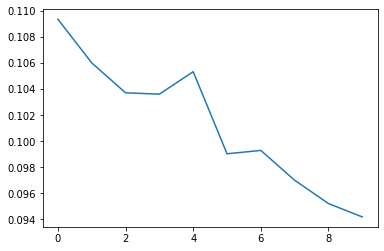

In [23]:
max_iterations = 10
l = []
for i in range(max_iterations):
    expdesign_loop.run_loop(pde_client, 1)
    cost_model.fit()
    X_new = np.array([i.X for i in expdesign_loop.loop_state.results])
    Y_new = np.array([i.Y for i in expdesign_loop.loop_state.results])
    model_variance = IntegratedVarianceReduction(model=expdesign_loop.model,space=space,x_monte_carlo=x_monte_carlo)
    weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
    plot(np.vstack((X,X_new)),np.vstack((Y,Y_new)),weighted_variance)
    l.append(expdesign_loop.model.model.param_array[1])
    print(l)
plt.plot(l)

    

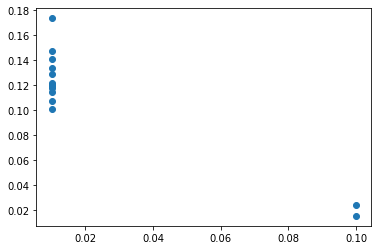

In [24]:
c = np.array(pde_client.cost)
plt.scatter(c[:,0],c[:,1])

In [14]:
c

array([[1.00000000e-01, 1.30030000e-02],
       [1.00000000e-01, 1.25050000e-02],
       [1.00000000e-03, 1.29276500e+00],
       [1.00000000e-03, 8.94164000e-01],
       [9.83664234e-02, 1.33130000e-02],
       [9.61952714e-02, 1.66200000e-02],
       [9.47962398e-02, 1.56140000e-02],
       [6.83332655e-02, 2.10260000e-02],
       [7.39543890e-02, 1.54170000e-02],
       [7.39848260e-02, 2.19320000e-02],
       [5.90936809e-02, 2.30100000e-02],
       [6.35657293e-02, 2.31700000e-02],
       [6.20279015e-02, 2.92630000e-02],
       [5.37062865e-02, 2.38010000e-02]])